## First - Prepareing Datasets
# 1.Convert Vector to Raster (Rasterize) with reference coordinate system from raster tiff

all these tools made for prepare data for paddlepaddlea.

In [51]:
from osgeo import gdal, ogr

- fn_ras = Input raster data (GTiff)
- fn_vec = input vector data (Shapefile)

In [52]:
fn_ras = 'DataSet/raster/01/01.tif'
fn_vec = 'DataSet/vector/01/01.shp'
output = 'DataSet/results/lab_all_values.tif'

import the GDAL driver "ESRI Shapefile" to open the shapefile

In [53]:
driver = ogr.GetDriverByName("ESRI Shapefile")

open raster and shapefile datasets with (shapefile , 1)
- (shapefile , 1) read and write in the shapefile
- (shapefile , 0) read onle the shapefile

In [54]:
ras_ds = gdal.Open(fn_ras)
vec_ds = driver.Open(fn_vec, 1)

Get the :
- GetLayer (Only shapefiles have one lyrs other fomates maybe have multi-lyrs) #VECTOR
- GetGeoTransform #FROM RASTER
- GetProjection #FROM RASTER

In [58]:
lyr = vec_ds.GetLayer()
geot = ras_ds.GetGeoTransform()
proj = ras_ds.GetProjection() # Get the projection from original tiff (fn_ras)
geot

(342940.8074133941,
 0.18114600000000536,
 0.0,
 3325329.401211367,
 0.0,
 -0.1811459999999247)

Open the shapefile feature to edit in it

In [61]:
layerdefinition = lyr.GetLayerDefn()
feature = ogr.Feature(layerdefinition)

```feature.GetFieldIndex``` make you to know the id of a specific field name you want to read/edit/delete
- Also you can list all fields on the shapefile by :
```
schema = []
    for n in range(layerdefinition.GetFieldCount()):
        fdefn = layerdefinition.GetFieldDefn(n)
        schema.append(fdefn.name)
```
- Then I will delete the field called "MLDS" has been assumed by me

In [ ]:
yy = feature.GetFieldIndex("MLDS")
if yy < 0:
    print("MLDS field not found, we will create one for you and make all values to 1")
else:
    lyr.DeleteField(yy)

add new field to the shapefile with a default value ```"1"``` and don't forget to close feature after the edits

In [ ]:
new_field = ogr.FieldDefn("MLDS", ogr.OFTInteger)
lyr.CreateField(new_field)
for feature in lyr:
        feature.SetField("MLDS", 1)
        lyr.SetFeature(feature)
        feature = None

Set the projection from original tiff (fn_ras) to the rasterized tiff

In [ ]:
drv_tiff = gdal.GetDriverByName("GTiff")
chn_ras_ds = drv_tiff.Create(
        output, ras_ds.RasterXSize, ras_ds.RasterYSize, 1, gdal.GDT_Byte)
chn_ras_ds.SetGeoTransform(geot)
chn_ras_ds.SetProjection(proj)
chn_ras_ds.FlushCache()

In [ ]:
gdal.RasterizeLayer(chn_ras_ds, [1], lyr, burn_values=[1], options=["ATTRIBUTE=MLDS"])
chn_ras_ds = None
vec_ds = None

DONE

## Second - Splitting raster and rasterized files to small tiles 512×512 depends on your memory

In [67]:
ds = gdal.Open(fn_ras)
gt = ds.GetGeoTransform()

get coordinates of upper left corner

In [68]:
xmin = gt[0]
ymax = gt[3]
resx = gt[1]
res_y = gt[5]
resy = abs(res_y)

In [69]:
import math
import os.path as osp

the tile size i want (may be 256×256 for smaller memory size)

In [74]:
needed_out_x = 512
needed_out_y = 512

round up to the nearest int

In [78]:
xnotround = ds.RasterXSize / needed_out_x
xround = math.ceil(xnotround)
ynotround = ds.RasterYSize / needed_out_y
yround = math.ceil(ynotround)

print(xnotround)
print(xround)
print(ynotround)
print(yround)

9.30078125
10
5.689453125
6


pixel to meter - 512×10×0.18

In [81]:
pixtomX = needed_out_x * xround * resx
pixtomy = needed_out_y * yround * resy

print (pixtomX)
print (pixtomy)

927.4675200000274
556.4805119997686


size of a single tile

In [83]:
xsize = pixtomX / xround
ysize = pixtomy / yround

print (xsize)
print (ysize)

92.74675200000274
92.74675199996143


create lists of x and y coordinates

In [84]:
xsteps = [xmin + xsize * i for i in range(xround + 1)]
ysteps = [ymax - ysize * i for i in range(yround + 1)]
xsteps

[342940.8074133941,
 343033.5541653941,
 343126.3009173941,
 343219.0476693941,
 343311.7944213941,
 343404.54117339413,
 343497.28792539414,
 343590.03467739414,
 343682.78142939415,
 343775.5281813941,
 343868.2749333941]

set the output path

In [85]:
cdpath = "DataSet/image/"

loop over min and max x and y coordinates

In [ ]:
for i in range(xround):
    for j in range(yround):
        xmin = xsteps[i]
        xmax = xsteps[i + 1]
        ymax = ysteps[j]
        ymin = ysteps[j + 1]

        # gdal translate to subset the input raster

        gdal.Translate(osp.join(cdpath,  \
                        (str("01") + "-" + str(j) + "-" + str(i) + "." + "jpg")), 
                ds, 
                projWin=(abs(xmin), abs(ymax), abs(xmax), abs(ymin)),
                xRes=resx, 
                yRes=-resy, 
                outputType=gdal.gdalconst.GDT_Byte, 
                format="JPEG")
ds = None

### Third - Spilit Custom Dataset and Generate File List

For all data that is not divided into training set, validation set, and test set, PaddleSeg provides a script to generate segmented data and generate a file list.

#### Use scripts to randomly split the custom dataset proportionally and generate a file list
The data file structure is as follows:
```
./dataset/  # Dataset root directory
|--images  # Original image catalog
|  |--xxx1.jpg (xx1.png)
|  |--...
|  └--...
|
|--annotations  # Annotated image catalog
|  |--xxx1.png
|  |--...
|  └--...
```

Among them, the corresponding file name can be defined according to needs.

The commands used are as follows, which supports enabling specific functions through different Flags.
```
python tools/split_dataset_list.py <dataset_root> <images_dir_name> <labels_dir_name> ${FLAGS}
```
Parameters:
- dataset_root: Dataset root directory
- images_dir_name: Original image catalog
- labels_dir_name: Annotated image catalog

FLAGS:

|FLAG|Meaning|Default|Parameter numbers|
|-|-|-|-|
|--split|Dataset segmentation ratio|0.7 0.3 0|3|
|--separator|File list separator|"&#124;"|1|
|--format|Data format of pictures and label sets|"jpg"  "png"|2|
|--label_class|Label category|'\_\_background\_\_' '\_\_foreground\_\_'|several|
|--postfix|Filter pictures and label sets according to whether the main file name (without extension) contains the specified suffix|""   ""（2 null characters）|2|


After running, `train.txt`, `val.txt`, `test.txt` and `labels.txt` will be generated in the root directory of the dataset.

**Note:** Requirements for generating the file list: either the original image and the number of annotated images are the same, or there is only the original image without annotated images. If the dataset lacks annotated images, a file list without separators and annotated image paths will be generated.

#### Example
```
python tools/split_dataset_list.py <dataset_root> images annotations --split 0.6 0.2 0.2 --format jpg png
```



## Dataset file organization

* If you need to use a custom dataset for training, it is recommended to organize it into the following structure:
    custom_dataset
        |
        |--images
        |  |--image1.jpg
        |  |--image2.jpg
        |  |--...
        |
        |--labels
        |  |--label1.png
        |  |--label2.png
        |  |--...
        |
        |--train.txt
        |
        |--val.txt
        |
        |--test.txt

The contents of train.txt and val.txt are as follows:

    images/image1.jpg labels/label1.png
    images/image2.jpg labels/label2.png
    ...
Full Docs : https://github.com/PaddlePaddle/PaddleSeg/blob/release/2.3/docs/data/custom/data_prepare.md

In [1]:
import sys
import subprocess

if in docker/ubuntu run this

In [3]:
! python split_dataset_list.py DataSet image label --format jpg png

Creating train.txt...
image/01-3-3.jpg label/01-3-3.png

image/01-5-5.jpg label/01-5-5.png

image/01-0-7.jpg label/01-0-7.png

image/01-0-9.jpg label/01-0-9.png

image/01-5-9.jpg label/01-5-9.png

image/01-5-3.jpg label/01-5-3.png

image/01-5-7.jpg label/01-5-7.png

image/01-4-5.jpg label/01-4-5.png

image/01-4-3.jpg label/01-4-3.png

image/01-1-0.jpg label/01-1-0.png

image/01-1-1.jpg label/01-1-1.png

image/01-0-6.jpg label/01-0-6.png

image/01-5-0.jpg label/01-5-0.png

image/01-4-8.jpg label/01-4-8.png

image/01-2-1.jpg label/01-2-1.png

image/01-5-8.jpg label/01-5-8.png

image/01-0-5.jpg label/01-0-5.png

image/01-2-9.jpg label/01-2-9.png

image/01-0-2.jpg label/01-0-2.png

image/01-3-1.jpg label/01-3-1.png

image/01-1-6.jpg label/01-1-6.png

image/01-4-9.jpg label/01-4-9.png

image/01-0-0.jpg label/01-0-0.png

image/01-3-5.jpg label/01-3-5.png

image/01-0-4.jpg label/01-0-4.png

image/01-4-1.jpg label/01-4-1.png

image/01-2-7.jpg label/01-2-7.png

image/01-2-4.jpg label/01-2-4.png

if on windows run but first defien your root, image, and label folders

In [ ]:
theproc = subprocess.Popen([
"python", 
r"C:\Users\Youss\Documents\pp\New folder\split-rs-data\split_dataset_list.py", #Split text py script
r"C:\Users\Youss\Documents\pp\New folder\split-rs-data\DataSet",  # Root DataSet ath
r"C:\Users\Youss\Documents\pp\New folder\split-rs-data\DataSet\image",  #images path
r"C:\Users\Youss\Documents\pp\New folder\split-rs-data\DataSet\label", 
# "--split", 
# "0.6",  # 60% training
# "0.2",  # 20% validating
# "0.2",  # 20% testing
"--format", 
"jpg", 
"png"])
theproc.communicate()

# Install paddleseg

In [ ]:
! pip install -q paddleseg

In [88]:
# Create data_list.txt
import os
import random
from PIL import Image


def create_list(data_path):
    image_path = os.path.join(data_path, 'image')
    label_path = os.path.join(data_path, 'label')
    data_names = os.listdir(image_path)
    random.shuffle(data_names)  # Scramble data
    with open(os.path.join(data_path, 'train.txt'), 'w') as tf:
        with open(os.path.join(data_path, 'val.txt'), 'w') as vf:
            for idx, data_name in enumerate(data_names):
                img = os.path.join('image', data_name)
                lab = os.path.join('label', data_name.replace('jpg', 'png'))
                if idx % 9 == 0:  # 90% as the training set
                    vf.write(img + ' ' + lab + '\n')
                else:
                    tf.write(img + ' ' + lab + '\n')
    print('Data list generation completed')

data_path = 'DataSet'
# create_list(data_path)  # Generate data list

In [90]:
# Prepare dataset
import paddleseg.transforms as T
from paddleseg.datasets import Dataset


# Build the training set
train_transforms = [
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(),
        T.RandomScaleAspect(),
        T.RandomDistort(),
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
train_dataset = Dataset(
    transforms=train_transforms,
    dataset_root='DataSet',
    num_classes=2,
    mode='train',
    train_path='DataSet/train.txt',
    separator=' '
)
# Build validation set
val_transforms = [
    T.Resize(target_size=(512, 512)),
    T.Normalize()
]
val_dataset = Dataset(
    transforms=val_transforms,
    dataset_root='DataSet',
    num_classes=2,
    mode='val',
    val_path='DataSet/val.txt',
    separator=' '
)

(3, 512, 512) (512, 512)
[  0 255]


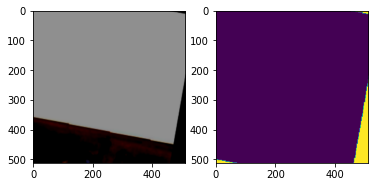

In [108]:
# View data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


for img, lab in train_dataset:
    print(img.shape, lab.shape)
    print(np.unique(lab))
    plt.subplot(121);plt.imshow(img.transpose((1, 2, 0)))
    plt.subplot(122);plt.imshow(lab)
    break

## Download a pretrained PaddlePaddle Model

In [109]:
import paddle
from paddleseg.models import OCRNet, HRNet_W18
from paddleseg.models.losses import MixedLoss, BCELoss, DiceLoss


base_lr=3e-4
iters=100
batch_size=8

model = OCRNet(num_classes=2,
               backbone=HRNet_W18(pretrained="https://bj.bcebos.com/paddleseg/dygraph/hrnet_w18_ssld.tar.gz"),
               backbone_indices=[0])

lr = paddle.optimizer.lr.PolynomialDecay(base_lr, decay_steps=iters//5, power=0.9)
optimizer = paddle.optimizer.Adam(lr, parameters=model.parameters())
losses = {}
losses['types'] = [MixedLoss([BCELoss(), DiceLoss()], [1, 1])] * 2
losses['coef'] = [1] * 2

2021-12-03 19:34:46 [INFO]	Loading pretrained model from https://bj.bcebos.com/paddleseg/dygraph/hrnet_w18_ssld.tar.gz
2021-12-03 19:34:48 [INFO]	There are 1525/1525 variables loaded into HRNet.


if you have nvidia gpu with cuda drivers installed you can check it

In [110]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
## nvidia-smi

## Start Training

In [111]:
from paddleseg.core import train


train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='output',
    iters=iters,
    batch_size=batch_size,
    save_interval=iters//5,
    log_iters=10,
    num_workers=0,
    losses=losses,
    use_vdl=True)

C:\Users\Youss\AppData\Local\Programs\Python\Python37\lib\site-packages\paddle\nn\layer\norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


ValueError: (InvalidArgument) Illegal index value, Input(input) value should be less than Input(depth), but received input (255) not less than depth (2)
  [Hint: Expected p_in_data[i] < depth_, but received p_in_data[i]:255 >= depth_:2.] (at C:\home\workspace\Paddle_release\paddle/fluid/operators/one_hot_v2_op.h:66)
  [operator < one_hot_v2 > error]

## Evaluation

In [46]:
import paddle
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.datasets import Dataset
from paddleseg.core import evaluate

def eval_model(model_path=None):
    # Network definition
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # Build validation set
    val_transforms = [
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ]
    val_dataset = Dataset(
        transforms=val_transforms,
        dataset_root='DataSet',
        num_classes=2,
        mode='val',
        val_path='DataSet/val.txt',
        separator=' ',
    )
    evaluate(
        model,
        val_dataset
    )

eval_model(model_path='output/model_kp0.9085/model.pdparams')

2021-12-03 18:51:50 [INFO]	Start evaluating (total_samples: 18, total_iters: 18)...


18/18 [==============================] - 266s 15s/step - batch_cost: 14.7635 - reader cost: 0.0026


2021-12-03 18:56:15 [INFO]	[EVAL] #Images: 18 mIoU: 0.1116 Acc: 0.2231 Kappa: 0.0000 
2021-12-03 18:56:15 [INFO]	[EVAL] Class IoU: 
[0.2231 0.    ]
2021-12-03 18:56:15 [INFO]	[EVAL] Class Acc: 
[1. 0.]


## Results

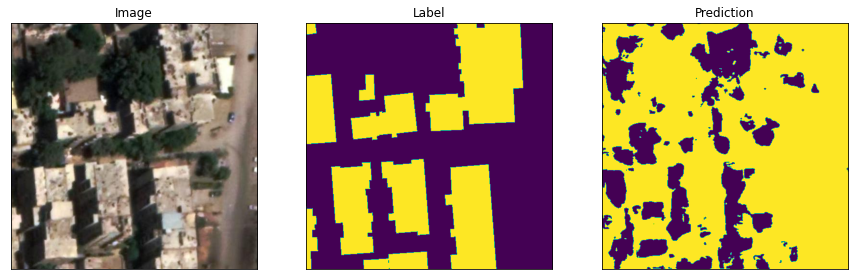

In [47]:
import numpy as np
import paddle
from PIL import Image
from paddleseg.models import UNetPlusPlus
import paddleseg.transforms as T
from paddleseg.core import infer
import matplotlib.pyplot as plt

def nn_infer(img_path, lab_path, model_path='output/model_kp0.9085/model.pdparams', show=True):
    # Network definition
    model = UNetPlusPlus(in_channels=3, num_classes=2, use_deconv=True)
    if model_path is not None:
        para_state_dict = paddle.load(model_path)
        model.set_dict(para_state_dict)
    # forecast result
    transforms = T.Compose([
        T.Resize(target_size=(512, 512)),
        T.Normalize()
    ])
    img, lab = transforms(img_path, lab_path)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
    if show:
        plt.figure(figsize=(15, 45))
        plt.subplot(131);plt.imshow(Image.open(img_path));plt.xticks([]);plt.yticks([]);plt.title('Image')
        plt.subplot(132);plt.imshow(lab.astype('uint8'));plt.xticks([]);plt.yticks([]);plt.title('Label')
        plt.subplot(133);plt.imshow(pred.astype('uint8'));plt.xticks([]);plt.yticks([]);plt.title('Prediction')
        plt.show()
    return pred.astype('uint8')

name = '01-2-7'
img_path = 'DataSet/image//' + name + '.jpg'
lab_path = 'DataSet/label//' + name + '.png'
_ = nn_infer(img_path, lab_path)

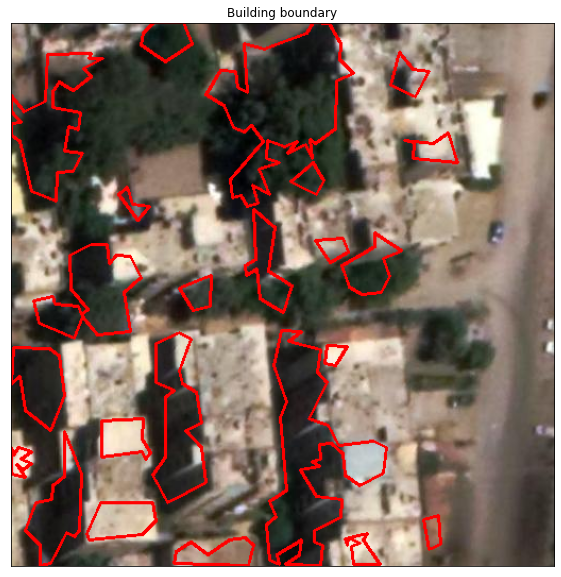

In [48]:
import cv2

def build_extracter(
    img_path,
    model_path='output/model_kp0.9085/model.pdparams',
    threshold_area=200,  # Remove the small threshold of the Unicom area
    threshold_area_simplify=5,  # Boundary simplification factor
    open_comput=False,  # Whether to open
    open_kernel_size=9,  # Core size for open operation
    show=True
    ):
    cv_img = nn_infer(img_path, lab_path, model_path, show=False)
    cv_img = np.uint8(~(cv_img.astype(bool)))
    # Open operation
    if open_comput:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_kernel_size, open_kernel_size))
        cv_img = cv2.morphologyEx(cv_img, cv2.MORPH_OPEN, kernel)
    contours, _ = cv2.findContours(cv_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bods = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > threshold_area:  # Screen the small connecting area
            out = cv2.approxPolyDP(contour, threshold_area_simplify, True)  # 简化形状
            bods.append(out)
    if show:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        cimg = cv2.drawContours(img, bods, -1, (255, 0, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.title('Building boundary')
        plt.imshow(cimg);plt.xticks([]);plt.yticks([])
        plt.show()
    return bods

conts = build_extracter(img_path)